# Random Forest Regressor Model

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

## Loading the data

In [123]:
df1 = pd.read_csv("../../data/DatasetCleanFinal.csv", sep=",")

In [62]:
df1.head()

,ActualLandingTime,Airline,AircraftType,RunwayNumber,StandNumber,Date,AWNDmean,PRCPmean,TAVGmean,WDF5mean,...,IceRoad,WetDay,ShipmentWeightCat,NbPlanesLast10Mn,Hour,WeekDay,ParkingArea,StandRank,TaxiTime,LogTaxiTime
0,2018-07-30 04:25:00,CAR1,B737/9-WL,2.0,4,2018-07-30 00:00:00,4.173333,0.006667,79.0,153.333333,...,0.0,1.0,M,0.0,4,0,16223.1,1,4.0,1.609438
1,2018-07-30 08:14:00,CAR1,B757/2-WL,2.0,7,2018-07-30 00:00:00,4.173333,0.006667,79.0,153.333333,...,0.0,1.0,M,0.0,8,0,20919.9,1,4.0,1.609438
2,2018-07-30 08:26:00,CAR1,A321/2,1.0,8,2018-07-30 00:00:00,4.173333,0.006667,79.0,153.333333,...,0.0,1.0,M,0.0,8,0,16337.8,1,3.0,1.386294
3,2018-07-30 08:42:00,CAR1,B737/9-WL,2.0,9,2018-07-30 00:00:00,4.173333,0.006667,79.0,153.333333,...,0.0,1.0,M,0.0,8,0,16223.1,1,4.0,1.609438
4,2018-07-30 08:52:00,CAR1,A321/2,2.0,11,2018-07-30 00:00:00,4.173333,0.006667,79.0,153.333333,...,0.0,1.0,M,0.0,8,0,16337.8,1,5.0,1.791759


We drop the AircraftType. We already put this information in the parking area column.

In [63]:
df1.drop(['AircraftType'], axis=1, inplace=True)

We drop useless columns

In [64]:
df1.drop(['ActualLandingTime', 'Date', 'StandNumber'], axis=1, inplace=True)

In [65]:
df1.shape

(129018, 22)

## One-Hot Encoding

As the Random Forest Regressor of scikit learn does not support categorical variables, we use One-Hot encoding.

In [66]:
df1.dtypes

Airline               object
RunwayNumber         float64
AWNDmean             float64
PRCPmean             float64
TAVGmean             float64
WDF5mean             float64
WSF2max              float64
WSF5max              float64
WT01max              float64
WT02max              float64
WT03max              float64
WT08max              float64
IceRoad              float64
WetDay               float64
ShipmentWeightCat     object
NbPlanesLast10Mn     float64
Hour                   int64
WeekDay                int64
ParkingArea          float64
StandRank              int64
TaxiTime             float64
LogTaxiTime          float64
dtype: object

In [67]:
df1['RunwayNumber'] = pd.Categorical(df1['RunwayNumber'])
df1['Airline'] = pd.Categorical(df1['Airline'])
df1['ShipmentWeightCat'] = pd.Categorical(df1['ShipmentWeightCat'])

In [68]:
dfDummiesRunwayNumber = pd.get_dummies(df1['RunwayNumber'], prefix = 'RunwayNumber')
dfDummiesAirline = pd.get_dummies(df1['Airline'], prefix = 'Airline')
dfDummiesShipmentWeightCat = pd.get_dummies(df1['ShipmentWeightCat'], prefix = 'ShipmentWeightCat')

In [69]:
df2 = pd.concat([df1, dfDummiesRunwayNumber, dfDummiesAirline, dfDummiesShipmentWeightCat], axis=1)

In [70]:
df2.shape

(129018, 39)

In [71]:
df2.head()

,Airline,RunwayNumber,AWNDmean,PRCPmean,TAVGmean,WDF5mean,WSF2max,WSF5max,WT01max,WT02max,...,RunwayNumber_7.0,RunwayNumber_8.0,RunwayNumber_9.0,Airline_CAR1,Airline_CAR2,Airline_CAR3,Airline_CAR4,ShipmentWeightCat_L,ShipmentWeightCat_M,ShipmentWeightCat_S
0,CAR1,2.0,4.173333,0.006667,79.0,153.333333,15.0,19.0,1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,CAR1,2.0,4.173333,0.006667,79.0,153.333333,15.0,19.0,1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,CAR1,1.0,4.173333,0.006667,79.0,153.333333,15.0,19.0,1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,CAR1,2.0,4.173333,0.006667,79.0,153.333333,15.0,19.0,1.0,0.0,...,0,0,0,1,0,0,0,0,1,0
4,CAR1,2.0,4.173333,0.006667,79.0,153.333333,15.0,19.0,1.0,0.0,...,0,0,0,1,0,0,0,0,1,0


## Creat input matrix and target columns

In [72]:
X = df2.drop(['TaxiTime', 'LogTaxiTime', 'RunwayNumber', 'Airline', 'ShipmentWeightCat'], axis=1)
y = df2['LogTaxiTime']

In [73]:
print(X.shape)
print(y.shape)

(129018, 34)
(129018,)


## Generate training & testing sets

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False,random_state=42)

In [75]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(103214, 34) (103214,)
(25804, 34) (25804,)


## Random Forest Regressor

In [112]:
rf = RandomForestRegressor(bootstrap=False, 
                           max_depth=100, 
                           max_features='sqrt', 
                           min_samples_leaf=4, 
                           min_samples_split=5, 
                           n_estimators=50, 
                           n_jobs =-1)

In [113]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [114]:
y_pred = np.exp(rf.predict(X_test))-1

In [115]:
y_pred[:10]

array([8.32739318, 6.01782022, 6.50840188, 7.00745709, 5.79146174,
       6.0407337 , 6.20824709, 5.79514786, 6.65575121, 5.59797446])

#### Compute RMSE score

In [116]:
np.sqrt(mean_squared_error(np.exp(y_test)-1, y_pred))

4.1680081148861845

#### Compute accuracy +/- 3 and 5 minutes

In [117]:
accuracy_dataframe = pd.DataFrame(data={'y_pred':y_pred, 'y_test':np.exp(y_test)-1})

In [118]:
accuracy_dataframe['3MinutesRange'] = abs(accuracy_dataframe['y_pred'] - accuracy_dataframe['y_test']) <= 3
accuracy_dataframe['5MinutesRange'] = abs(accuracy_dataframe['y_pred'] - accuracy_dataframe['y_test']) <= 5

In [119]:
print(accuracy_dataframe['3MinutesRange'].value_counts(normalize=True) * 100)

print(accuracy_dataframe['5MinutesRange'].value_counts(normalize=True) * 100)

True     81.929158
False    18.070842
Name: 3MinutesRange, dtype: float64
True     92.706557
False     7.293443
Name: 5MinutesRange, dtype: float64


#### Check features importance

In [84]:
from matplotlib import pyplot as plt

In [87]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[:15]

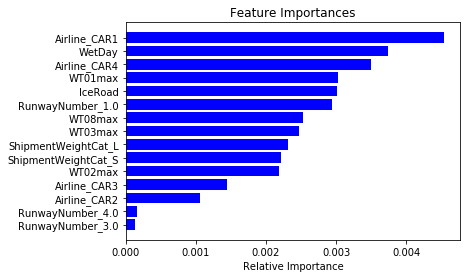

In [88]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [89]:
list(features[indices])

['RunwayNumber_3.0',
 'RunwayNumber_4.0',
 'Airline_CAR2',
 'Airline_CAR3',
 'WT02max',
 'ShipmentWeightCat_S',
 'ShipmentWeightCat_L',
 'WT03max',
 'WT08max',
 'RunwayNumber_1.0',
 'IceRoad',
 'WT01max',
 'Airline_CAR4',
 'WetDay',
 'Airline_CAR1']

## Grid Search

/!\ We need to be carefull with the cross validation since we are dealing with time series!

In [93]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [99]:
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [50]#[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50]}


/!\ Warning: takes a lot of time to execute

In [100]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = tscv, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.9min
[Paralle

RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [50], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=10)

In [101]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 50}

## Final RF model

Now that we know the optimal set of hyperparameters, we can build our final model and train it on the entire dataset

In [120]:
rf_final = RandomForestRegressor(bootstrap=False, 
                           max_depth=100, 
                           max_features='sqrt', 
                           min_samples_leaf=4, 
                           min_samples_split=5, 
                           n_estimators=50, 
                           n_jobs =-1)
rf_final.fit(X, y) #on full dataset

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=100,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=4, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## Pickle the final model for future use

In [121]:
import pickle
# save the model to disk
filename = 'finalized_random_forest_model.sav'
pickle.dump(rf_final, open(filename, 'wb'))